In [1]:
import xarray as xr 
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
from utils.utils import Fill_NC_With_Station_Values, aggregate_per_timestep_xr, calculate_metrics
from era5.era5_cropper import Era5ForStationCropper
from train_station_twin.prepare_training_executor_era5 import TrainingPreparation
import torch


In [2]:
prep = TrainingPreparation(base_dir='executed_trainings', station_name='Testting')


2024-12-02 15:48:02,434 INFO:Created station directory at executed_trainings/Testting_20241202-15.
2024-12-02 15:48:02,435 INFO:Created directory: executed_trainings/Testting_20241202-15/data
2024-12-02 15:48:02,436 INFO:Created directory: executed_trainings/Testting_20241202-15/model
2024-12-02 15:48:02,436 INFO:Created directory: executed_trainings/Testting_20241202-15/log
2024-12-02 15:48:02,437 INFO:Created directory: executed_trainings/Testting_20241202-15/data/train
2024-12-02 15:48:02,437 INFO:Created directory: executed_trainings/Testting_20241202-15/data/val
2024-12-02 15:48:02,437 INFO:Created directory: executed_trainings/Testting_20241202-15/data/test


In [3]:
prep.prepare_training_args(total_iterations=10000, output_path=None,
                              common_args_path=None,
                              input_filename='input.nc,input.nc,input.nc', output_filename='output.nc',
                              data_types_in="tp", data_types_out="tp",
                              n_target_data=1, encoding_layers="3,3,3,,3,3", pooling_layers=0,
                              device='cpu', out_channels=1,
                              loss_criterion=3, min_bounds=0, max_bounds=1)

2024-12-02 15:48:02,445 INFO:Common arguments written to executed_trainings/Testting_20241202-15/common_args.txt.
2024-12-02 15:48:02,446 INFO:Training arguments saved to executed_trainings/Testting_20241202-15/train_args.txt.


'executed_trainings/Testting_20241202-15/train_args.txt'

In [4]:
prep.prepare_eval_args()


2024-12-02 15:48:02,452 INFO:Training arguments saved to executed_trainings/Testting_20241202-15/eval_args.txt.


'executed_trainings/Testting_20241202-15/eval_args.txt'

In [11]:
# Load ERA5 Data
# this covers the period 2020-2023 and is in 9x9 grid
era5 = xr.open_dataset('era5_data/er5_newhook/vienna_allvar_2017-2024_renamed.nc')
if np.all(era5["10u"].isel(time=0).values == era5["10u"].isel(time=0).values.flat[0]):
    print( "10u is constant")

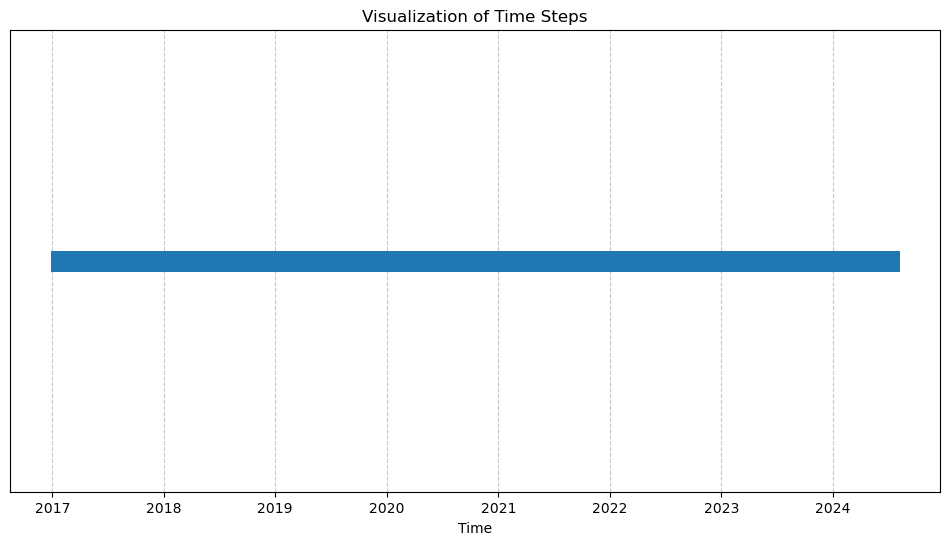

In [3]:
# Open your dataset

# Extract the time coordinate
time_steps = era5['time']

# Plot the time steps
plt.figure(figsize=(12, 6))
plt.plot(time_steps, [1] * len(time_steps), '|', markersize=15)  # Mark each timestep
plt.title("Visualization of Time Steps")
plt.xlabel("Time")
plt.yticks([])  # Hide y-axis labels
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [4]:
# load hourly station data
vienna_hourly_df = pd.read_csv("station_data_processed/vienna_hourly_aggregated_data.csv", index_col=0,  parse_dates=True)
vienna_hourly_df.head()
# barbados_hourly_df["tipping"].dropna()
vienna_hourly_df



,bmp280_temp,bmp280_pres,bmp280_slp,htu_temp,htu_hum,mcp9808,tipping,vis_light,ir_light,uv_light,wind_dir,wind_speed,u_wind,v_wind
datetime,,,,,,,,,,,,,,
2017-04-24 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,23.349669,NaN,NaN,NaN
2017-04-24 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,20.898067,NaN,NaN,NaN
2017-04-24 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,19.371252,NaN,NaN,NaN
2017-04-24 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.2,NaN,NaN,NaN,44.898214,0.398644,0.0,0.0
2017-04-24 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-24 12:00:00,23.13,989.470,1007.76,22.4,63.25,21.9,0.0,569.0,3174.0,167.0,205.080658,NaN,NaN,NaN
2022-05-24 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-24 14:00:00,22.81,989.420,1007.73,22.0,63.20,21.8,0.0,486.0,2275.0,123.0,180.022444,NaN,NaN,NaN


In [5]:

# Example station coordinates (e.g., Berlin)
station_lat =  48.2303,
station_lon =  16.3609


 
measurements = vienna_hourly_df["tipping"]

# Paths to ERA5 datasets
original_era5_path = 'era5_data/er5_newhook/vienna_allvar_2017-2024_renamed.nc'  # Replace with actual path
cropped_era5_path = 'Training_Vienna/new_2021train/tp/testing_cropped.nc'      # Replace with desired output path

# Initialize the cropper
cropper = Era5ForStationCropper(
    latitude=station_lat,
    longitude=station_lon,
    measurements=measurements,
    era5_path=original_era5_path,
    era5_target_path=cropped_era5_path
)

# Execute cropping and retrieve results
cropped_dataset, missing_gaps = cropper.execute()

print("Missing timestamps:", missing_gaps)


Cropping time axis...
Selecting time slice from 2017-04-24 07:00:00 to 2022-05-24 16:00:00
Time-cropped dataset dimensions: Frozen({'time': 44554, 'lon': 17, 'lat': 17})
Dropping missing times...
Number of missing timestamps: 12478
Dataset dimensions after dropping missing times: Frozen({'time': 32076, 'lon': 17, 'lat': 17})
Cropping spatial grid...
Latitudes are sorted in descending order.
Longitudes are sorted in ascending order.
Nearest longitude: 16.36 (Index: 8)
Nearest latitude: 48.2305 (Index: 8)
Final cropping indices: start=5, end=12
Final cropping indices: start=5, end=12
Cropping longitude indices: 5 to 12
Cropping latitude indices: 5 to 12
Dataset dimensions after spatial cropping: Frozen({'time': 32076, 'lon': 8, 'lat': 8})
Longitude values after cropping: [15.61 15.86 16.11 16.36 16.61 16.86 17.11 17.36]
Latitude values after cropping: [48.9806875 48.730625  48.4805625 48.2305    47.9804375 47.730375
 47.4803125 47.23025  ]

Inspecting cropped dataset before saving:
<xarr

In [133]:
cropped_era5_path = 'Training_Vienna/new_2021train/tp/era5_cropped_tipping.nc'
cropped_era5 = xr.open_dataset(cropped_era5_path)
cropped_era5.tp.values

array([[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.000

In [134]:
# Fill NC with Values with ....
var = "tp"
values = vienna_hourly_df['tipping'].dropna().values
original_path = 'Training_Vienna/new_2021train/tp/era5_cropped_tipping.nc'   # Replace with desired output path
save_to_path = 'Training_Vienna/new_2021train/tp/filled_tp_gt.nc'

Fill_NC_With_Station_Values(var, values, original_path, save_to_path)



In [135]:
ground_truth_data_path = 'Training_Vienna/new_2021train/tp/filled_tp_gt.nc'
gt = xr.open_dataset(ground_truth_data_path)
gt.tp.values[1150:1160]



array([[[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]],

       [[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ]],

       [[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.

In [179]:
# Path to your ERA5 data file (optional)
      # Replace with desired output path

cropped_era5_path = 'Training_Vienna/new_2021train/tp/era5_cropped_tipping.nc'   # Replace with desired output path
ground_truth_data_path = 'Training_Vienna/new_2021train/tp/filled_tp_gt.nc'

In [180]:

input = xr.open_dataset(cropped_era5_path)
gt = xr.open_dataset(ground_truth_data_path)



In [181]:
# year 2021 for test
input_2021 = input.where(input["time"].dt.year == 2021 , drop=True)
gt_2021 = gt.where(gt["time"].dt.year == 2021 , drop=True)

# train and val
gt_wo_2021 = gt.where(gt["time"].dt.year != 2021 , drop=True)
input_wo_2021 = input.where(input["time"].dt.year != 2021 , drop=True)


In [182]:
# non zero 
gt_wo_2021_nonzero = gt_wo_2021.where(gt_wo_2021.tp > 0, drop=True)
filtered_non_zero_times_wo21 = gt_wo_2021_nonzero.time
gt_wo_2021_nonzero = gt_wo_2021.sel(time=filtered_non_zero_times_wo21)
input_wo_2021_nonzero = input_wo_2021.sel(time=filtered_non_zero_times_wo21)

gt_2021_nonzero = gt_2021.where(gt_2021.tp > 0, drop=True)
filtered_non_zero_times_21 = gt_2021_nonzero.time
gt_non_zero_21 = gt_2021.sel(time=filtered_non_zero_times_21)
input_non_zero_21 = input_2021.sel(time=filtered_non_zero_times_21)


In [5]:
def split_and_save_data_with_ratio(xr_gt, xr_era5, split_ratio, 
                                   gt_train_file, era5_train_file, 
                                   gt_val_file, era5_val_file, 
                                   gt_test_file, era5_test_file, shuffle=False):
    """
    Split the dataset into train, validation, and test sets with optional shuffling,
    and save them to NetCDF files.
    
    Args:
        xr_gt: xarray dataset containing ground truth data.
        xr_era5: xarray dataset containing ERA5 data.
        split_ratio: Tuple of split ratios (train, validation, test).
        gt_train_file: File path for ground truth training set.
        era5_train_file: File path for ERA5 training set.
        gt_val_file: File path for ground truth validation set.
        era5_val_file: File path for ERA5 validation set.
        gt_test_file: File path for ground truth test set.
        era5_test_file: File path for ERA5 test set.
    """    
    # Calculate split indices
    total_length = xr_gt.sizes['time']
    indices = np.arange(total_length)
    if shuffle:
        np.random.shuffle(indices)

    train_end = int(total_length * split_ratio[0])
    val_end = train_end + int(total_length * split_ratio[1])
    
    # Get shuffled indices for each split
    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]
    
    # Split and save the datasets
    xr_gt.isel(time=train_indices).to_netcdf(gt_train_file)
    xr_era5.isel(time=train_indices).to_netcdf(era5_train_file)
    
    if len(val_indices) > 0:  # Ensure validation indices are present
        xr_gt.isel(time=val_indices).to_netcdf(gt_val_file)
        xr_era5.isel(time=val_indices).to_netcdf(era5_val_file)
    
    if len(test_indices) > 0:  # Ensure test indices are present
        xr_gt.isel(time=test_indices).to_netcdf(gt_test_file)
        xr_era5.isel(time=test_indices).to_netcdf(era5_test_file)


# Define the split ratio as (train, validation, test)
split_ratio = (0.85, 0.15, 0)  # 80% train, 10% validation, 10% test

# Define the file paths for each split
gt_train_file = 'Training_Vienna/new_2021train/tp/split_nonzero/vienna_filltas_train_gt.nc'
era5_train_file = 'Training_Vienna/new_2021train/tp/split_nonzero/vienna_input_train.nc'
gt_val_file = 'Training_Vienna/new_2021train/tp/split_nonzero/vienna_filltas_val_gt.nc'
era5_val_file = 'Training_Vienna/new_2021train/tp/split_nonzero/vienna_input_val.nc'
gt_test_file = 'Training_Vienna/new_2021train/tp/split_nonzero/vienna_filltas_test_gt.nc'
era5_test_file = 'Training_Vienna/new_2021train/tp/split_nonzero/vienna_input_test.nc'

# Run the function
split_and_save_data_with_ratio(gt_wo_2021_nonzero, input_wo_2021_nonzero, split_ratio, 
                               gt_train_file, era5_train_file, 
                               gt_val_file, era5_val_file, 
                               gt_test_file, era5_test_file)


NameError: name 'gt_wo_2021_nonzero' is not defined

In [190]:
# check 
gt_train = xr.open_dataset("Training_Vienna/new_2021train/tp/split_nonzero/vienna_input_test.nc")
gt_train_filtered = gt_train.where(gt_train.tp > 0, drop=True)
tp_values = gt_train_filtered.tp.values
gt_train

<xarray.Dataset>
Dimensions:  (time: 414, lat: 8, lon: 8)
Coordinates:
  * time     (time) datetime64[ns] 2021-01-02T22:00:00 ... 2021-12-30T18:00:00
  * lon      (lon) float64 15.36 15.61 15.86 16.11 16.36 16.61 16.86 17.11
  * lat      (lat) float64 49.23 48.98 48.73 48.48 48.23 47.98 47.73 47.48
Data variables:
    10u      (time, lat, lon) float32 ...
    10v      (time, lat, lon) float32 ...
    dt2m     (time, lat, lon) float32 ...
    t2m      (time, lat, lon) float32 ...
    sp       (time, lat, lon) float32 ...
    tp       (time, lat, lon) float32 0.5609 0.482 0.3787 ... 0.1227 0.04798
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Mon Nov 18 16:34:30 2024: cdo -f nc4 copy era5_data/er5_new...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...

In [189]:
#input_2021 = input.where(input["time"].dt.year == 2021 , drop=True)
input_non_zero_21.to_netcdf(era5_test_file)
#gt_2021 = gt.where(gt["time"].dt.year == 2021 , drop=True)
gt_non_zero_21.to_netcdf(gt_test_file)

In [191]:
# Initialize the class
prep = TrainingPreparation(base_dir='executed_trainings', station_name='Testting')




2024-11-29 15:17:00,198 INFO:Created station directory at executed_trainings/Vienna_tp_nonzero_new_20241129-15.
2024-11-29 15:17:00,201 INFO:Created directory: executed_trainings/Vienna_tp_nonzero_new_20241129-15/data
2024-11-29 15:17:00,202 INFO:Created directory: executed_trainings/Vienna_tp_nonzero_new_20241129-15/model
2024-11-29 15:17:00,203 INFO:Created directory: executed_trainings/Vienna_tp_nonzero_new_20241129-15/log
2024-11-29 15:17:00,204 INFO:Created directory: executed_trainings/Vienna_tp_nonzero_new_20241129-15/data/train
2024-11-29 15:17:00,205 INFO:Created directory: executed_trainings/Vienna_tp_nonzero_new_20241129-15/data/val
2024-11-29 15:17:00,206 INFO:Created directory: executed_trainings/Vienna_tp_nonzero_new_20241129-15/data/test


In [6]:
prep.copy_and_prepare_data(
    dataset_type='train',
    input_src=era5_train_file,
    output_src=gt_train_file
)

# Copy and prepare validation data
prep.copy_and_prepare_data(
    dataset_type='val',
    input_src=era5_val_file,
    output_src=gt_val_file,
)

# Copy and prepare test data
prep.copy_and_prepare_data(
    dataset_type='test',
    input_src=era5_test_file,
    output_src=gt_test_file
)


2024-12-02 15:48:14,702 INFO:Starting to copy and prepare data for train dataset.
2024-12-02 15:48:14,707 INFO:Copied input file from Training_Vienna/new_2021train/tp/split_nonzero/vienna_input_train.nc to executed_trainings/Testting_20241202-15/data/train/input.nc.
2024-12-02 15:48:14,963 INFO:No variables have constant data over lat-lon at time executed_trainings/Testting_20241202-15/data/train/input.nc
2024-12-02 15:48:15,130 INFO:Converted executed_trainings/Testting_20241202-15/data/train/input.nc to float32.
2024-12-02 15:48:15,134 INFO:Copied output file from Training_Vienna/new_2021train/tp/split_nonzero/vienna_filltas_train_gt.nc to executed_trainings/Testting_20241202-15/data/train/output.nc.
2024-12-02 15:48:15,142 INFO:Variables with constant data over lat-lon at time executed_trainings/Testting_20241202-15/data/train/output.nc : ['tp']
2024-12-02 15:48:15,151 INFO:Converted executed_trainings/Testting_20241202-15/data/train/output.nc to float32.
2024-12-02 15:48:15,164 INF

In [193]:
prep.prepare_training_args(total_iterations=10000, output_path=None,
                              common_args_path=None,
                              input_filename=['input.nc',"input.nc","input.nc"], output_filename='output.nc',
                              data_types_in="tp", data_types_out="tp",
                              n_target_data=1, encoding_layers=3, pooling_layers=0,
                              device='cpu', n_filters=18, out_channels=1,
                              loss_criterion=3)

2024-11-29 15:17:08,864 INFO:Common arguments written to executed_trainings/Vienna_tp_nonzero_new_20241129-15/common_args.txt.
2024-11-29 15:17:08,883 INFO:Training arguments saved to executed_trainings/Vienna_tp_nonzero_new_20241129-15/train_args.txt.


'executed_trainings/Vienna_tp_nonzero_new_20241129-15/train_args.txt'

In [204]:
model_path = "executed_trainings/Vienna_tp_nonzero_sixvar_new_20241129-15/model/ckpt"
evaluation_output_dir = "executed_trainings/Vienna_tp_nonzero_sixvar_new_20241129-15/model"

prep.prepare_eval_args(model_path, evaluation_output_dir, output_path=None)


2024-11-29 15:53:22,042 INFO:Training arguments saved to executed_trainings/Vienna_tp_nonzero_new_20241129-15/eval_args.txt.


'executed_trainings/Vienna_tp_nonzero_new_20241129-15/eval_args.txt'

In [213]:
output_output = xr.open_dataset("executed_trainings/Vienna_tp_nonzero_sixvar_new_20241129-15/model/output_output.nc")
output_gt = xr.open_dataset("executed_trainings/Vienna_tp_nonzero_sixvar_new_20241129-15/model/output_gt.nc")

In [214]:
output_gt.tp.values

array([[[0.20000005, 0.20000005, 0.20000005, ..., 0.20000005,
         0.20000005, 0.20000005],
        [0.20000005, 0.20000005, 0.20000005, ..., 0.20000005,
         0.20000005, 0.20000005],
        [0.20000005, 0.20000005, 0.20000005, ..., 0.20000005,
         0.20000005, 0.20000005],
        ...,
        [0.20000005, 0.20000005, 0.20000005, ..., 0.20000005,
         0.20000005, 0.20000005],
        [0.20000005, 0.20000005, 0.20000005, ..., 0.20000005,
         0.20000005, 0.20000005],
        [0.20000005, 0.20000005, 0.20000005, ..., 0.20000005,
         0.20000005, 0.20000005]],

       [[0.20000005, 0.20000005, 0.20000005, ..., 0.20000005,
         0.20000005, 0.20000005],
        [0.20000005, 0.20000005, 0.20000005, ..., 0.20000005,
         0.20000005, 0.20000005],
        [0.20000005, 0.20000005, 0.20000005, ..., 0.20000005,
         0.20000005, 0.20000005],
        ...,
        [0.20000005, 0.20000005, 0.20000005, ..., 0.20000005,
         0.20000005, 0.20000005],
        [0.2

In [215]:

# Example usage
aggregated_output_output = aggregate_per_timestep_xr(output_output, methods=["mean", "std", "var", "max"], variables=["tp"])
aggregated_output_gt = aggregate_per_timestep_xr(output_gt,  methods=["mean", "std", "var", "max"], variables=["tp"])
#aggregated_input_gt = aggregate_per_timestep_xr(input_gt,  methods=["mean", "std", "var", "max"], variables=["10v"])


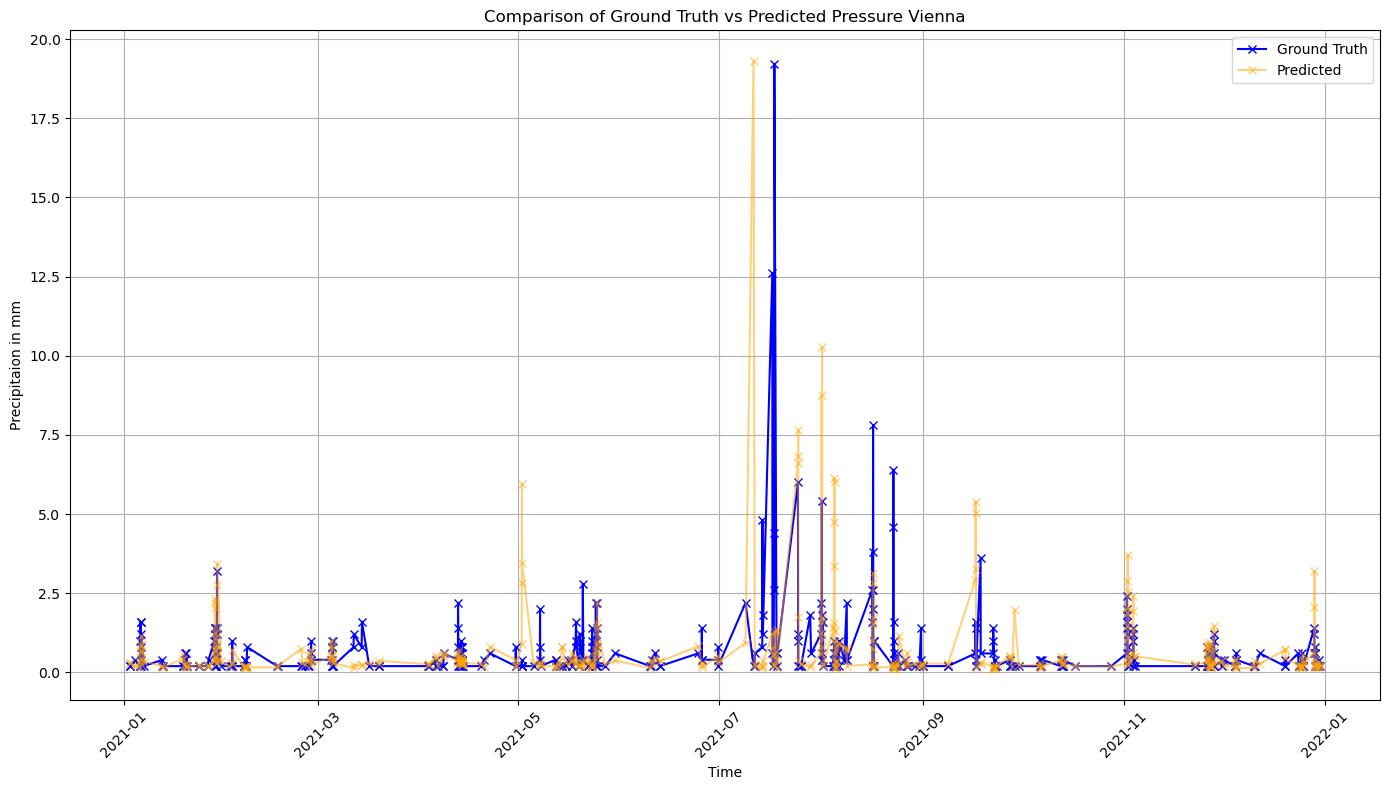

In [216]:
def improved_plot_datasets(ds1: xr.DataArray, ds2: xr.DataArray, title1="Ground Truth", title2="Predicted"):
    """
    Improved plot for two xarray DataArrays over time, with enhancements.

    Parameters:
    ds1 (xr.DataArray): First DataArray to plot.
    ds2 (xr.DataArray): Second DataArray to plot.
    title1 (str): Label for the first dataset.
    title2 (str): Label for the second dataset.
    """
    # Align datasets to ensure they share the same time axis
    ds1, ds2 = xr.align(ds1, ds2)

    # Create a larger figure
    plt.figure(figsize=(14, 8))

    # Plot each dataset with markers and handle missing values (NaN)
    plt.plot(ds1.time, ds1.where(~ds1.isnull()), label=title1, marker='x', linestyle='-', color='blue')
    plt.plot(ds2.time, ds2.where(~ds2.isnull()), label=title2, marker='x', linestyle='-', color='orange', alpha=0.5)

    # Adding labels, title, and legend
    plt.xlabel('Time')
    #plt.ylim(950, 1050)  # Note: reversed y-axis

    plt.ylabel('Precipitaion in mm')
    plt.title('Comparison of Ground Truth vs Predicted Pressure Vienna')
    plt.legend()

    # Rotate x-axis labels and add grid for better readability
    plt.xticks(rotation=45)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Usage
improved_plot_datasets(aggregated_output_gt.mean_tp, aggregated_output_output.mean_tp )


In [120]:
# Load the ERA5 dataset
era5_ds  = xr.open_dataset('era5_data/er5_newhook/vienna_allvar_2017-2024_renamed.nc')

# Define the target latitude and longitude
station_lat = 48.2303
station_lon =  16.3609   # Example: Vienna longitude

# Select the nearest grid point
nearest_grid_point = era5_ds.sel(lat=station_lat, lon=station_lon, method="nearest")


# Access a specific variable if needed
variable_nearest_grid = nearest_grid_point["tp"] 

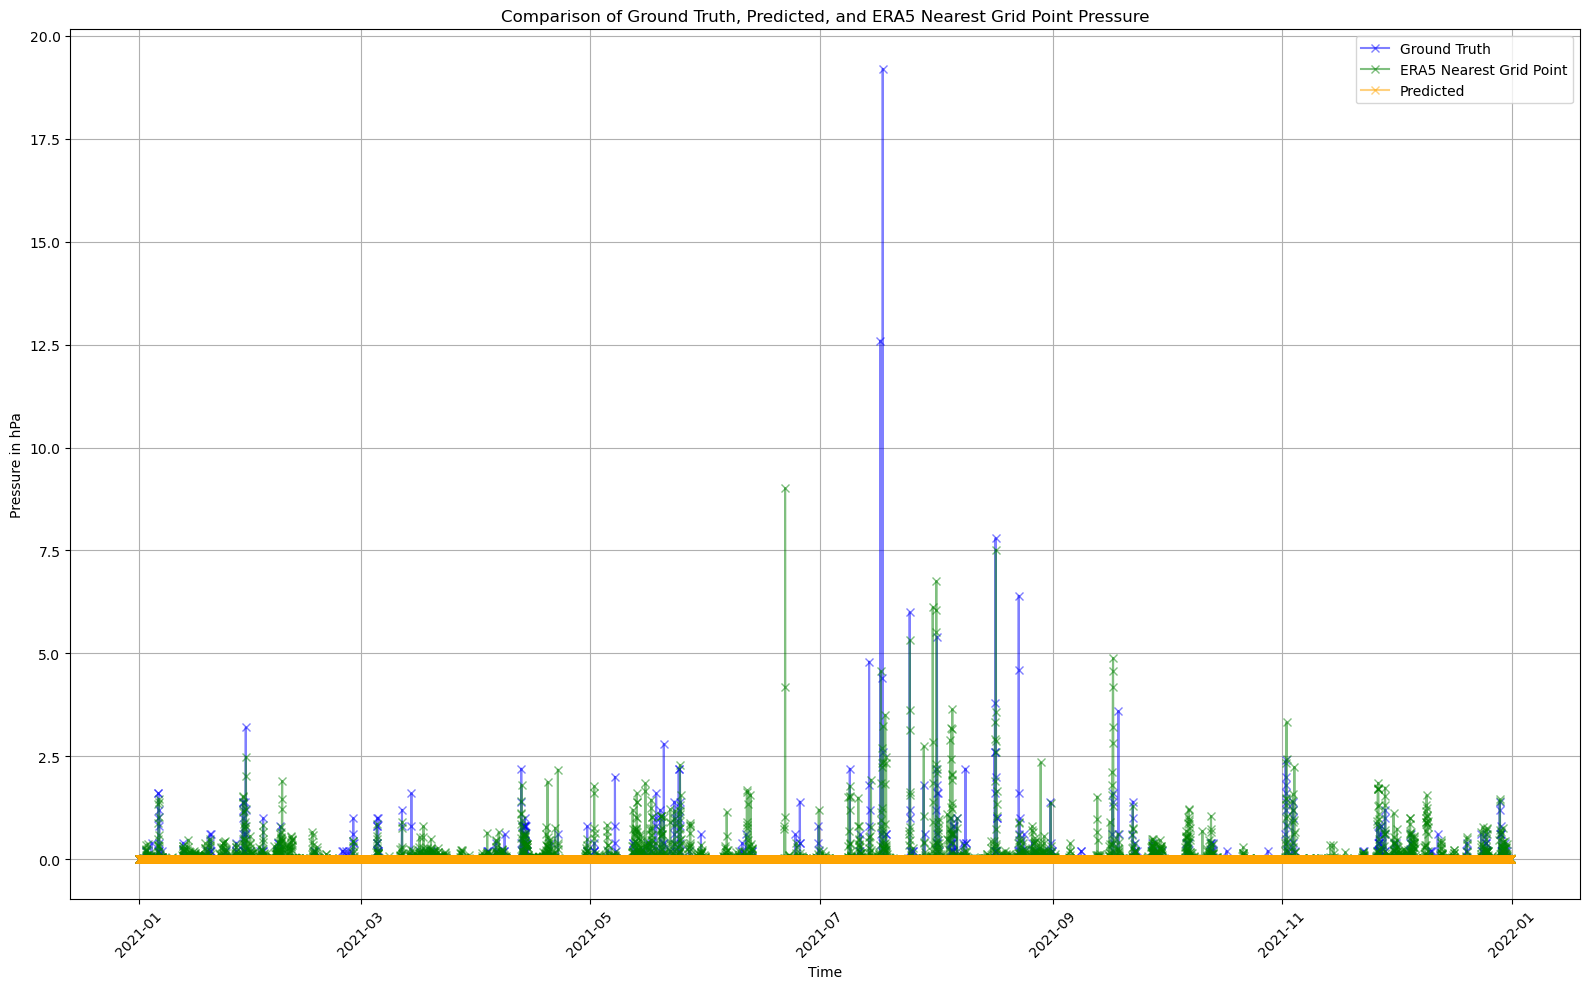

In [124]:


def improved_plot_datasets(ds1: xr.DataArray, ds2: xr.DataArray, ds3: xr.DataArray,
                           title1="Ground Truth", title2="Predicted", title3="ERA5 Nearest Grid Point"):
    """
    Improved plot for three xarray DataArrays over time, with enhancements.

    Parameters:
    ds1 (xr.DataArray): First DataArray to plot (e.g., Ground Truth).
    ds2 (xr.DataArray): Second DataArray to plot (e.g., Predicted).
    ds3 (xr.DataArray): Third DataArray to plot (e.g., ERA5 Nearest Grid Point).
    title1 (str): Label for the first dataset.
    title2 (str): Label for the second dataset.
    title3 (str): Label for the third dataset.
    """
    # Align datasets to ensure they share the same time axis
    ds1, ds2, ds3 = xr.align(ds1, ds2, ds3)

    # Create a larger figure
    plt.figure(figsize=(16, 10))

    # Plot each dataset with markers and handle missing values (NaN)
    plt.plot(ds1.time, ds1.where(~ds1.isnull()), label=title1, marker='x', linestyle='-', color='blue', alpha=0.5)
    plt.plot(ds3.time, ds3.where(~ds3.isnull()), label=title3, marker='x', linestyle='-', color='green', alpha=0.5)

    plt.plot(ds2.time, ds2.where(~ds2.isnull()), label=title2, marker='x', linestyle='-', color='orange', alpha=0.5)

    # Adding labels, title, and legend
    plt.xlabel('Time')
    plt.ylabel('Pressure in hPa')
    plt.title('Comparison of Ground Truth, Predicted, and ERA5 Nearest Grid Point Pressure')
    plt.legend()

    # Rotate x-axis labels and add grid for better readability
    plt.xticks(rotation=45)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Usage
improved_plot_datasets(aggregated_output_gt.mean_tp, aggregated_output_output.mean_tp, variable_nearest_grid)


In [217]:
# Example usage
metrics = calculate_metrics(aggregated_output_gt.mean_tp, aggregated_output_output.mean_tp , var="tp", output_path= "executed_trainings/Vienna_tp_nonzero_sixvar_new_20241129-15/model/metrics.txt")



In [218]:
print(metrics)


{'R^2': -0.9498010043403975, 'RMSE': 1.9427611, 'Pearson Correlation': 0.09880590244539543}
